## This notebook will walk you through cleaning up noisy V4 Miniscope data

Post questions or issues to the Miniscope Google Group: https://groups.google.com/g/miniscope

You will need the following packages installed (you likely should create a virtual python environment using conda or similar). You can use 'pip install <package name> 

* opencv-python
* numpy
* matplotlib
* tqdm
* scipy
* ipympl
* ipython

If a video is playing you can hit 'q' to quit the playback

- Aharoni Lab
- 09/18/2020


In [9]:
import os.path
from os import path
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 
from scipy.signal import butter, lfilter, freqz, filtfilt


# Need pip install ipympl
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

Enter the path to where your V4 Miniscope videos are saved.

In [10]:
# directory where videos are stored


# Data files should be .avi's and have the following form:
# '<dataDir><dataFilePrefix><startingFileNum>.avi'

# Values users can modify:
dataDir = "C:\\Users\\ryanz\\Documents\\calcium_imaging\\raw\\IL16-24-086\\IL16-24-086\\2025_02_28\\13_28_56\My_V4_Miniscope"
dataFilePrefix = ''
framesPerFile = 1000 # This is the default setting for the Miniscope software. If you changed it in software change it here too.


We will now play back the video and calculate the mean 2D FFT of the played back frames. You can chage 'frameStep' to speed this up. We generally don't need tons of frames for calculating the mean 2D FFT of the video.

In [11]:
# Run through avi files and generate mean fft

# Values users can modify:
frameStep = 1 # Can use frame skipping to speed this up
showVideo = True
# -----------------------

fileNum = 0
sumFFT = None
applyVignette = True
vignetteCreated = False
running = True

In [12]:
#cropping variables
crop = False
cropped_dir = "C:\\Users\\ryanz\\Documents\\calcium_imaging\\raw\\IL16-24-086\\IL16-24-086\\2025_02_28\\13_28_56\My_V4_MiniscopeCropped"
y1, y2, x1, x2 = 0, 450, 0, 450
new_width = x2 - x1
new_height = y2 - y1
os.makedirs(cropped_dir, exist_ok=True)


#crop video
if crop:
    while (path.exists(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum)) and running is True):
        
        #data paths
        input_path = dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum)
        output_path = cropped_dir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum)
        
        #import video
        cap = cv2.VideoCapture(input_path)
        
        #define video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        #generate new video writer
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(cropped_dir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum), fourcc, fps, (new_width, new_height))
            
        #crop each frame
        for frameNum in tqdm(range(0, int(framesPerFile / frameStep)), total = int(framesPerFile / frameStep), desc ="Running file {:.0f}.avi".format(fileNum)):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
            ret, frame = cap.read()
            if (ret is False):
                break      
            
            cropped_frame = frame[y1:y2, x1:x2]
            out.write(cropped_frame)
        
        
        fileNum = fileNum + 1
        cap.release()
        out.release()
        
    cv2.destroyAllWindows()


In [13]:
#use cropped videos
dataDir = cropped_dir

while (path.exists(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum)) and running is True):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum))
    
    fileNum = fileNum + 1
    frameNum = 0
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        ret, frame = cap.read()

        if (vignetteCreated is False):
            rows, cols = frame.shape[:2] 
            X_resultant_kernel = cv2.getGaussianKernel(cols,cols/4) 
            Y_resultant_kernel = cv2.getGaussianKernel(rows,rows/4) 
            resultant_kernel = Y_resultant_kernel * X_resultant_kernel.T 
            mask = 255 * resultant_kernel / np.linalg.norm(resultant_kernel)
            vignetteCreated = True

        if applyVignette is False:
            mask = mask * 0 + 1
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1] * mask
            
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT)
            dft_shift = np.fft.fftshift(dft)
             
            try:
                sumFFT = sumFFT + cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
            except:
                sumFFT = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

            if (showVideo is True):
                cv2.imshow("Vid", frame/255)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    running = False
                    break

cv2.destroyAllWindows()

Running file 0.avi: 100%|██████████| 1000/1000.0 [00:30<00:00, 32.72it/s]
Running file 1.avi:  80%|███████▉  | 795/1000.0 [00:24<00:06, 33.01it/s]


We will now display the mean 2D FFT and show what sort of spatial filtering we want to apply. Generally the V4 Miniscope noise shows up as a vertical line with a few bright spots (these are the spatial frequencies related to the dim, scrolling horizontal stripes).

We want to filter these stripes out while not disturbing the actual imaging data. 

Below shows an example mean 2D FFT. Spatial frequencies due to the horizontal lines show up in the red boxes. The spatial frequencies in the green circle are mostly from the real data and you want to keep as much of this as possible while still removing most of the horizontal stripes.

<p align="center">
  <img width="300" src="img\2D-FFT-example.PNG">
</p>

C:\Users\ryanz\AppData\Local\Temp\ipykernel_10040\346333833.py:29: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122),plt.imshow(np.log(modifiedFFT), cmap = 'gray')


Text(0.5, 1.0, 'Filtered FFT')

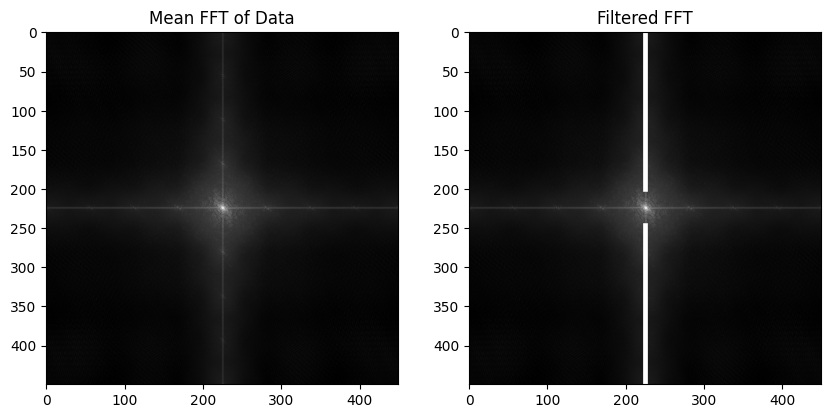

In [14]:
# Modify FFT using a circle mask around center

# Values users can modify:
goodRadius = 2000
notchHalfWidth = 3
centerHalfHeightToLeave = 20
# -----------------------

crow,ccol = int(rows/2) , int(cols/2)

maskFFT = np.zeros((rows,cols,2), np.float32)
cv2.circle(maskFFT,(crow,ccol),goodRadius,1,thickness=-1)

# for i in cutFreq:
#     maskFFT[(i + crow-notchHalfWidth):(i+crow+notchHalfWidth),(ccol-notchHalfWidth):(ccol+notchHalfWidth),0] = 0
#     maskFFT[(-i + crow-notchHalfWidth):(-i+crow+notchHalfWidth),(ccol-notchHalfWidth):(ccol+notchHalfWidth),0] = 0
maskFFT[(crow+centerHalfHeightToLeave):,(ccol-notchHalfWidth):(ccol+notchHalfWidth),0] = 0
maskFFT[:(crow-centerHalfHeightToLeave),(ccol-notchHalfWidth):(ccol+notchHalfWidth),0] = 0

maskFFT[:,:,1] = maskFFT[:,:,0]


modifiedFFT = sumFFT * maskFFT[:,:,0]

# Plot original and modified FFT
plt.figure()
plt.subplot(121),plt.imshow(np.log(sumFFT), cmap = 'gray')
plt.title('Mean FFT of Data')
plt.subplot(122),plt.imshow(np.log(modifiedFFT), cmap = 'gray')
plt.title('Filtered FFT')

Now we will display the raw, filtered, and difference video.

If things were done correctly, the filtered video show have the horizontal stripes removed and the difference video should pretty much only show those stripes (with maybe a tiny bit of other horizontal structure)

In [17]:
# Display filtered vs original videos

# Values users can modify:
frameStep = 3 # This will speed up the playback
# -----------------------
startingFileNum = 0
fileNum = startingFileNum
sumFFT = None
running = True

while (path.exists(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum)) and running is True):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum))
    fileNum = fileNum + 1
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        ret, frame = cap.read()
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1]
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT|cv2.DFT_SCALE)
            dft_shift = np.fft.fftshift(dft)
             
            fshift = dft_shift * maskFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = cv2.idft(f_ishift)
            img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
            
            img_back[img_back >255] = 255
            img_back = np.uint8(img_back)

            im_diff = (128 + (frame - img_back)*2)
            im_v = cv2.hconcat([frame, img_back, im_diff])
            cv2.imshow("Raw, Filtered, Difference", im_v/255)

            try:
                sumFFT = sumFFT + cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
            except:
                sumFFT = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

            if cv2.waitKey(10) & 0xFF == ord('q'):
                running = False
                break

cv2.destroyAllWindows()

Now we will correct the other source of V4 Miniscope noise. This is a fast, ~+3Hz fluctuation of the brightness of the entire field of view. 

* We will first run through the data and calculate the mean intensity of every frame.
* Next we will apply a lowpass filter to the mean intensity over time
* Finally we will scale the imaging data by the percentage difference of raw and filtered mean intensity.

In [18]:
# Calculate mean fluorescence per frame

# Users shouldn't change anything here
frameStep = 1 # Should stay as 1
fileNum = startingFileNum
sumFFT = None
meanFrameList = []


while (path.exists(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum))):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum))
    fileNum = fileNum + 1
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        ret, frame = cap.read()
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1]
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT|cv2.DFT_SCALE)
            dft_shift = np.fft.fftshift(dft)
             
            fshift = dft_shift * maskFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = cv2.idft(f_ishift)
            img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
            meanFrameList.append(img_back.mean())
            
            #clear_output(wait=True)

            #plt.subplot(121),plt.imshow(frame, cmap = 'gray')
            #plt.title('Input Image'), plt.xticks([]), plt.yticks([])
            #plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
            #plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

            #plt.show()
            
meanFrame = np.array(meanFrameList)

Running file 0.avi:   0%|          | 0/1000.0 [00:00<?, ?it/s]

Running file 0.avi: 100%|██████████| 1000/1000.0 [00:08<00:00, 116.21it/s]
Running file 1.avi:  80%|███████▉  | 795/1000.0 [00:06<00:01, 115.66it/s]


In [19]:
meanFrame

array([26.758226, 26.908396, 26.752792, ..., 26.719612, 26.821718,
       26.840572], shape=(1795,), dtype=float32)

Now we will generate a lowpass filter

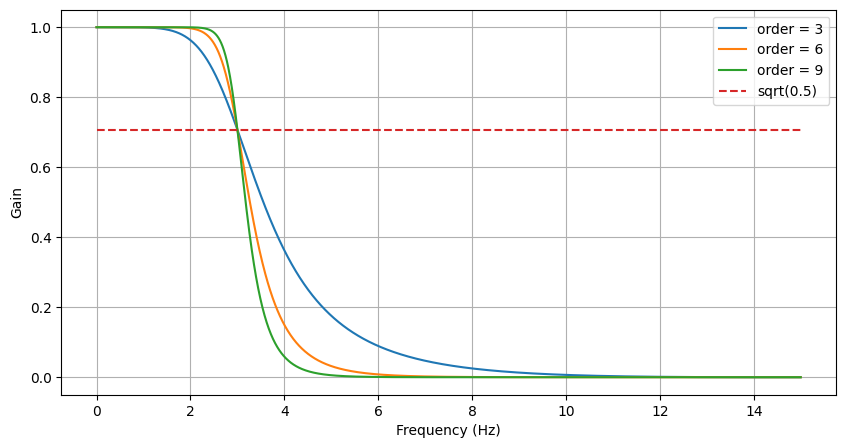

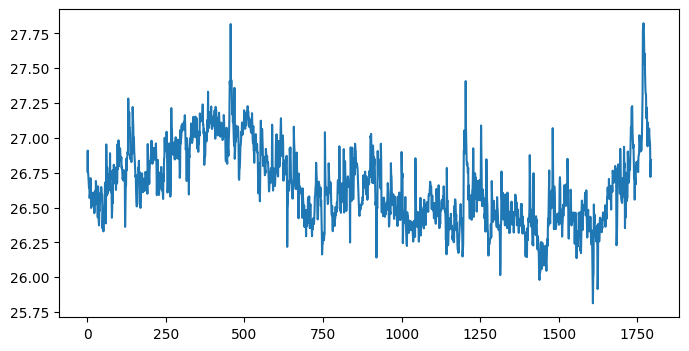

In [20]:
# Create a lowpass filter
# Sample rate and desired cutoff frequencies (in Hz).

# Values users can modify:
fs = 30 # TODO: Should get this from timestamp file
cutoff = 3.0
# -----------------------

plt.figure()
for order in [3, 6, 9]:
    b, a = butter(order, cutoff/ (0.5 * fs), btype='low', analog = False)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
# Plot Mean Frame Resuls
plt.figure(figsize=(8,4))
plt.plot(meanFrame)

Now select which order of the filter you want to use and then we will apply that filter to the mean intensity of frames across the recording.

Zoom into the plotted traces to check if the filtering removed high freqency noise but left the rest of the mean intensity trace unchanged.

It should look something like this with the Filtered Data following the trend of the Raw Data but with the higher frequency fluctuations removed:

<p align="center">
  <img width="400" src="img\filtered_data_example.PNG">
</p>


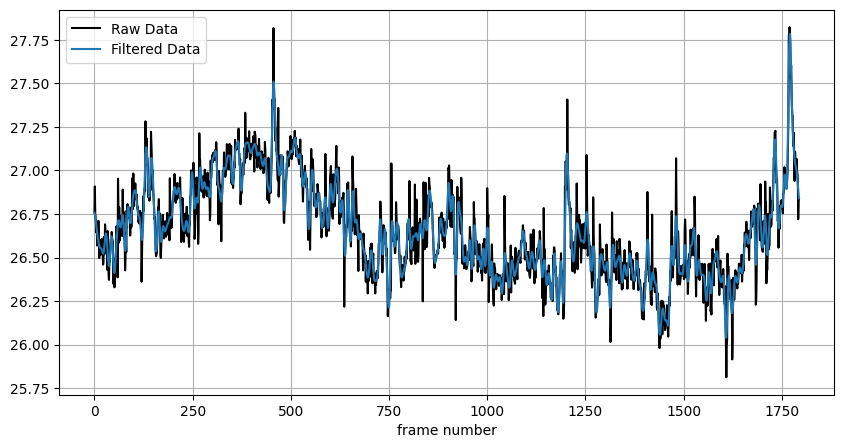

In [21]:
# Plot effect of filtering

# Values users can modify:
butterOrder = 6
# -----------------------

b, a = butter(butterOrder, cutoff/ (0.5 * fs), btype='low', analog = False)
meanFiltered = filtfilt(b,a,meanFrame)
plt.figure()
plt.plot(meanFrame, 'k', label='Raw Data')
plt.plot( meanFiltered, label='Filtered Data')
#plt.plot(meanFrame - meanFiltered,'r', label='Difference')
plt.xlabel('frame number')
# plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
# meanFrame[3000]

Finally we will apply both the 2D FFT spatial filtering and the lowpass mean intensity filtering to the raw data.

You can select between displaying the results and saving the results. If saving, the 'frameStep' should be set to 1.


In [22]:
# Apply FFT spatial filtering and lowpass filtering to data and has the option of saving as new videos

# Values users can modify:
# Select one below -
# mode = "display"
mode = 'save'

frameStep = 1 #1 # Should be set to 1 for saving

# Select one below -
compressionCodec = "FFV1"
# compressionCodec = "GREY"
# --------------------

fileNum = 0
sumFFT = None
frameCount = 0
running = True

if (mode is "save" and frameStep is not 1):
    print("WARNING: You are only saving every {} frame!".format(frameStep))

codec = cv2.VideoWriter_fourcc(compressionCodec[0],compressionCodec[1],compressionCodec[2],compressionCodec[3])

if (mode is "save" and not path.exists(dataDir + "Denoised")):
    os.mkdir(dataDir + "Denoised")

while (path.exists(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum)) and running is True):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "\\{:.0f}.avi".format(fileNum))

    if (mode is "save"):
        writeFile = cv2.VideoWriter(dataDir + "Denoised\\" + dataFilePrefix + "\\denoised{:.0f}.avi".format(fileNum),  
                            codec, 60, (cols,rows), isColor=False) 

    fileNum = fileNum + 1
    # frameNum = 0
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        ret, frame = cap.read()
        # frameNum = frameNum + frameStep 
        
        # print(frameCount)
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1]
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT|cv2.DFT_SCALE)
            dft_shift = np.fft.fftshift(dft)
             
            fshift = dft_shift * maskFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = cv2.idft(f_ishift)
            img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

            meanF = img_back.mean()
            img_back = img_back * (1 + (meanFiltered[frameCount] - meanF)/meanF)
            img_back[img_back >255] = 255
            img_back = np.uint8(img_back)

            
            
            if (mode is "save"):
                writeFile.write(img_back)

            if (mode is "display"):
                im_diff = (128 + (frame - img_back)*2)
                im_v = cv2.hconcat([frame, img_back])
                im_v = cv2.hconcat([im_v, im_diff])

                im_v = cv2.hconcat([frame, img_back, im_diff])
                cv2.imshow("Cleaned video", im_v/255)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    running = False
                    cap.release()
                    break

            frameCount = frameCount + 1

    if (mode is "save"):
        writeFile.release()

cv2.destroyAllWindows()


<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\ryanz\AppData\Local\Temp\ipykernel_10040\366178449.py:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  